## Deep Learning Project - Classification of Histopathology Images

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd 'drive/MyDrive'

/content/drive/MyDrive


In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, Input, BatchNormalization

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from seaborn import heatmap 
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Model No.1 - InceptionV3

The two main innovations in Inception architecture is the Inception block and the Intermediate Classifier.

The Inception blocks allow for variations in the salient parts of the picture, meaning the same feature can come in different sizes in various pictures and one of the convolutions should detect it with no problem.

Intermediate Classifiers solve the problem of the vanishing gradient in networks that use a deep architecture.

In this model we didn't use any data augmentation.
For training the new top an RMSProp optimizer was used.
For Fine tuning, an SGD optimizer was used with a learning rate of 1e-4, since our goal in fine tuning is to move more gently towards the optimum point.

We achieved an accuracy of over 89% with this model.

In [ ]:
# Loading the data, for the first model we only rescale the data, without using any kind of augmentation
M1_dataGen = ImageDataGenerator(rescale=1./255)
M1_train_generator = M1_dataGen.flow_from_directory('Deep_Learning_Project_Data/Kather_texture_2016_image_tiles_5000/train', target_size=(150,150), batch_size=128)

M1_validationGen = ImageDataGenerator(rescale=1./255)
M1_validation_generator = M1_validationGen.flow_from_directory('Deep_Learning_Project_Data/Kather_texture_2016_image_tiles_5000/validation', target_size=(150,150), batch_size=128)

Found 4630 images belonging to 8 classes.
Found 490 images belonging to 8 classes.


In [ ]:
M1 = Sequential()

# Loading the InceptionV3 model without the "top" 
from tensorflow.keras.applications import InceptionV3

M1.add(InceptionV3(include_top=False, input_shape=(150,150,3)))

# Adding a new "top" layer 
M1.add(Flatten())
M1.add(Dense(1024, activation='relu'))
M1.add(Dropout(0.5))
M1.add(Dense(8, activation="softmax"))

# Freezing the weights in InceptionV3 (First layer of our model)
M1.layers[0].trainable = False
M1.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              18875392  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 8200      
Total params: 40,686,376
Trainable params: 18,883,592
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
# Compiling the model with RMSProp gradient descent optimizer
M1.compile(optimizer='rmsprop', # RMSprop
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Training the model with validation
H1 = M1.fit(M1_train_generator, epochs=40, verbose=1,
               steps_per_epoch=M1_train_generator.samples//128,
               validation_data=M1_validation_generator)

plot_results(H1)

In [ ]:
M1.layers[0].trainable = True

# Compiling the model now with all the weights available
my_opt = keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)

M1.compile(optimizer=my_opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine tuning the weights of the model for a few more epochs to give us more accuracy
H11 = M1.fit(M1_train_generator, epochs=30, verbose=1,
               steps_per_epoch=M1_train_generator.samples//128,
               validation_data=M1_validation_generator)

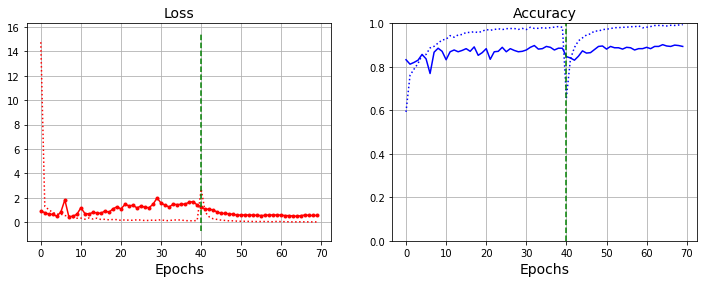

In [ ]:
# Plotting the loss and accuracy of the model along both training stages
loss = H1.history['loss'] + H11.history['loss']
accuracy = H1.history['accuracy'] + H11.history['accuracy']
val_loss = H1.history['val_loss'] + H11.history['val_loss']
val_accuracy = H1.history['val_accuracy'] + H11.history['val_accuracy']


plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(loss,':r')
plt.plot(val_loss,'.-r')
plt.plot([40,40], plt.ylim(),'--g')
plt.title('Loss',fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.grid()

plt.subplot(1,2,2)
plt.plot(accuracy,':b')
plt.plot(val_accuracy,'b')
plt.ylim([0, 1])
plt.plot([40,40], plt.ylim(),'--g')
plt.title('Accuracy',fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.grid()

In [ ]:
# Saving the model to disk so we can load it without having to train it again in the future
M1.save('Saved_Models/InceptionV3')

INFO:tensorflow:Assets written to: Saved_Models/InceptionV3/assets


## Model No.2 - Transfer Learning + Fine Tuning with a Pre trained VGG-19 model

The VGG-19 has 16 convolutional layers and 3 fully connected layers. Making it a very powerful classifier.
It is a deeper version of it predecessor VGG-16.

Of course, for our purposes we have removed the 3 fully connected layers at the end and trained our own "top", so our architecture uses 17 layers in total.

The same optimizers were used here.
RMSProp for training the top and SGD for fine tuning.

We achieved an accuracy of over 93% with this model.

In [ ]:
# Loading the data, we apply some data augmentation to get more robust results
M2_dataGen = ImageDataGenerator(rescale=1./255, rotation_range =180, horizontal_flip = True, vertical_flip = True, shear_range=0.2, zoom_range=0.2)
M2_train_generator = M2_dataGen.flow_from_directory('Deep_Learning_Project_Data/Kather_texture_2016_image_tiles_5000/train', target_size=(224,224), batch_size=128)

M2_validationGen = ImageDataGenerator(rescale=1./255)
M2_validation_generator = M2_validationGen.flow_from_directory('Deep_Learning_Project_Data/Kather_texture_2016_image_tiles_5000/validation', target_size=(224,224), batch_size=128)

Found 4630 images belonging to 8 classes.
Found 490 images belonging to 8 classes.


In [ ]:
M2 = Sequential()

# Loading the VGG-19 model without the "top" 
from tensorflow.keras.applications import VGG19

M2.add(VGG19(include_top=False, input_shape=(224,224,3)))

# Adding a new "top" layer 
M2.add(Flatten())
M2.add(Dense(256, activation='relu'))
M2.add(Dropout(0.5))
M2.add(Dense(8, activation="softmax"))

# Freezing the weights in VGG-19 (First layer of our model)
M2.layers[0].trainable = False
M2.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 2056      
Total params: 26,449,224
Trainable params: 6,424,840
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
# Compiling the model with RMSProp gradient descent optimizer
M2.compile(optimizer='rmsprop', # RMSprop
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Training the model with validation
H2 = M2.fit(M2_train_generator, epochs=40, verbose=1,
               steps_per_epoch=M2_train_generator.samples//128,
               validation_data=M2_validation_generator)

plot_results(H2)

In [ ]:
M2.layers[0].trainable = True

# Compiling the model now with all the weights available
my_opt = keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)

M2.compile(optimizer=my_opt, # SGD
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine tuning the weights of the model for a few more epochs to give us more accuracy
H22 = M2.fit(M2_train_generator, epochs=30, verbose=1,
               steps_per_epoch=M2_train_generator.samples//128,
               validation_data=M2_validation_generator)



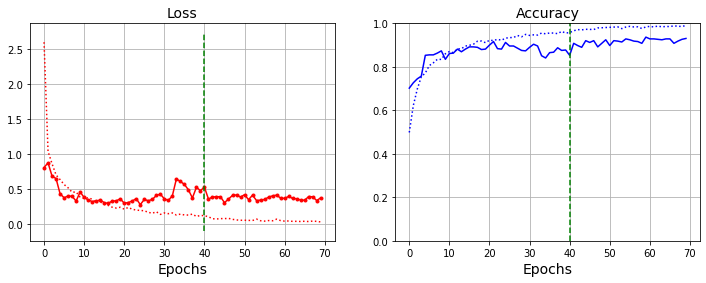

In [ ]:
# Plotting the loss and accuracy of the model along both training stages
loss = H2.history['loss'] + H22.history['loss']
accuracy = H2.history['accuracy'] + H22.history['accuracy']
val_loss = H2.history['val_loss'] + H22.history['val_loss']
val_accuracy = H2.history['val_accuracy'] + H22.history['val_accuracy']


plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(loss,':r')
plt.plot(val_loss,'.-r')
plt.plot([40,40], plt.ylim(),'--g')
plt.title('Loss',fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.grid()

plt.subplot(1,2,2)
plt.plot(accuracy,':b')
plt.plot(val_accuracy,'b')
plt.ylim([0, 1])
plt.plot([40,40], plt.ylim(),'--g')
plt.title('Accuracy',fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.grid()

In [ ]:
# Saving the model to disk so we can load it without having to train it again in the future
M2.save('Saved_Models/VGG19')

INFO:tensorflow:Assets written to: Saved_Models/VGG19/assets


## Model No.3 - VGG-19 + Adam Optimizer

Some research indicates that for problems that use the VGG architecture as a CNN,  Adam gave one of the best performances as a gradient descent optimizer. 

We tried using it here and it did indeed gave us a slightly better performance than the RMSProp oprimizer for the first stage of our training.

We achieved an accuracy of over 94% with this model.

In [ ]:
# Loading the data, we apply some data augmentation to get more robust results
M3_dataGen = ImageDataGenerator(rescale=1./255, rotation_range =180, horizontal_flip = True, vertical_flip = True, shear_range=0.2, zoom_range=0.2)
M3_train_generator = M3_dataGen.flow_from_directory('Deep_Learning_Project_Data/Kather_texture_2016_image_tiles_5000/train', target_size=(224,224), batch_size=128)

M3_validationGen = ImageDataGenerator(rescale=1./255)
M3_validation_generator = M3_validationGen.flow_from_directory('Deep_Learning_Project_Data/Kather_texture_2016_image_tiles_5000/validation', target_size=(224,224), batch_size=128)

Found 4630 images belonging to 8 classes.
Found 490 images belonging to 8 classes.


In [ ]:
M3 = Sequential()

# Loading the VGG-19 model without the "top" 
from tensorflow.keras.applications import VGG19

M3.add(VGG19(include_top=False, input_shape=(224,224,3)))

# Adding a new "top" layer 
M3.add(Flatten())
M3.add(Dense(256, activation='relu'))
M3.add(Dropout(0.5))
M3.add(Dense(8, activation="softmax"))

# Freezing the weights in VGG-19 (First layer of our model)
M3.layers[0].trainable = False
M3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 2056      
Total params: 26,449,224
Trainable params: 6,424,840
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
# Compiling the model with Adam gradient descent optimizer
M3.compile(optimizer='adam', # Adam
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Training the model with validation
H3 = M3.fit(M3_train_generator, epochs=40, verbose=1,
               steps_per_epoch=M3_train_generator.samples//128,
               validation_data=M3_validation_generator)

plot_results(H3)

In [ ]:
M3.layers[0].trainable = True

# Compiling the model now with all the weights available
my_opt = keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)

M3.compile(optimizer=my_opt, # SGD
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine tuning the weights of the model for a few more epochs to give us more accuracy
H33 = M3.fit(M3_train_generator, epochs=30, verbose=1,
               steps_per_epoch=M3_train_generator.samples//128,
               validation_data=M3_validation_generator)



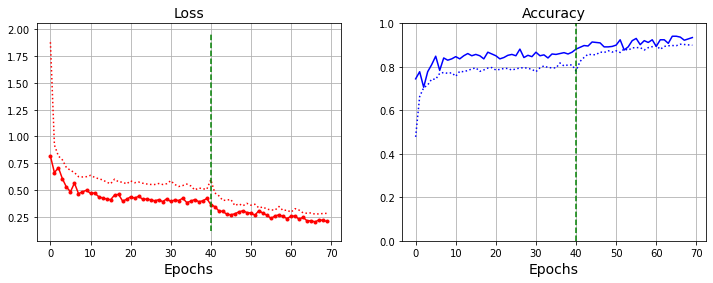

In [ ]:
# Plotting the loss and accuracy of the model along both training stages
loss = H3.history['loss'] + H33.history['loss']
accuracy = H3.history['accuracy'] + H33.history['accuracy']
val_loss = H3.history['val_loss'] + H33.history['val_loss']
val_accuracy = H3.history['val_accuracy'] + H33.history['val_accuracy']


plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(loss,':r')
plt.plot(val_loss,'.-r')
plt.plot([40,40], plt.ylim(),'--g')
plt.title('Loss',fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.grid()

plt.subplot(1,2,2)
plt.plot(accuracy,':b')
plt.plot(val_accuracy,'b')
plt.ylim([0, 1])
plt.plot([40,40], plt.ylim(),'--g')
plt.title('Accuracy',fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.grid()

In [ ]:
# Saving the model to disk so we can load it without having to train it again in the future
M3.save('Saved_Models/VGG19_Adam')

INFO:tensorflow:Assets written to: Saved_Models/VGG19_Adam/assets


## Model No.4 Xception

This is the latest cutting edge model using the Inception architecture.

It is the highest rated model on keras.io using the Top-5 Accuracy metric.

We chose to explore InceptionV3 and Xception because they both can natively accept a 150x150 resolution of images.
This saves a resizing step in the pre-processing and avoids using interpolation.

Here we used RMSProp as the "top" training optrimizer.
We used a more aggressive SGD optimizer for the fine-tuning stage with a learning rate of 1e-2.

We have achieved an accuracy of over 97% with this model.

In [ ]:
# Loading the data, we apply some data augmentation to get more robust results
M4_dataGen = ImageDataGenerator(rescale=1./255, rotation_range =180, horizontal_flip = True, vertical_flip = True, shear_range=0.2, zoom_range=0.2)
M4_train_generator = M4_dataGen.flow_from_directory('Deep_Learning_Project_Data/Kather_texture_2016_image_tiles_5000/train', target_size=(150,150), batch_size=128)

M4_validationGen = ImageDataGenerator(rescale=1./255)
M4_validation_generator = M4_validationGen.flow_from_directory('Deep_Learning_Project_Data/Kather_texture_2016_image_tiles_5000/validation', target_size=(150,150), batch_size=128)

Found 4630 images belonging to 8 classes.
Found 490 images belonging to 8 classes.


In [ ]:
M4 = Sequential()

# Loading the Xception model without the "top" 
from tensorflow.keras.applications import Xception

M4.add(Xception(include_top=False, input_shape=(150,150,3)))

# Adding a new "top" layer 
M4.add(Flatten())
M4.add(Dense(256, activation='relu'))
M4.add(Dropout(0.5))
M4.add(Dense(8, activation="softmax"))

# Freezing the weights in Xception (First layer of our model)
M4.layers[0].trainable = False
M4.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               13107456  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 2056      
Total params: 33,970,992
Trainable params: 13,109,512
Non-trainable params: 20,861,480
_________________________________________________________________


In [ ]:
# Compiling the model with RMSProp gradient descent optimizer
M4.compile(optimizer='rmsprop', # RMSprop
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Training the model with validation
H4 = M4.fit(M4_train_generator, epochs=40, verbose=1,
               steps_per_epoch=M4_train_generator.samples//128,
               validation_data=M4_validation_generator)

plot_results(H4)

In [ ]:
#M4.save('Saved_Models/Xception_Before_FT')
#M4 = tf.keras.models.load_model('Saved_Models/Xception_Before_FT')
M4.layers[0].trainable = True

# Compiling the model now with all the weights available
my_opt = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

M4.compile(optimizer=my_opt, # SGD
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine tuning the weights of the model for a few more epochs to give us more accuracy
H44 = M4.fit(M4_train_generator, epochs=30, verbose=1,
               steps_per_epoch=M4_train_generator.samples//128,
               validation_data=M4_validation_generator)



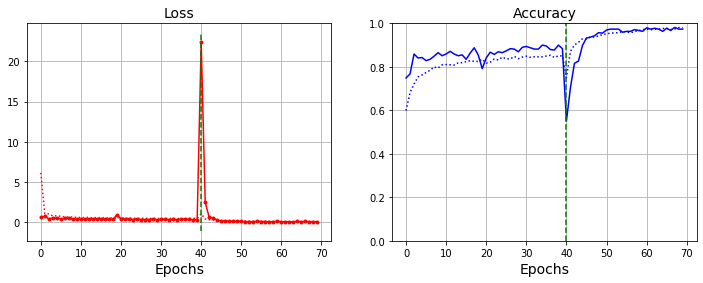

In [ ]:
# Plotting the loss and accuracy of the model along both training stages
loss = H4.history['loss'] + H44.history['loss']
accuracy = H4.history['accuracy'] + H44.history['accuracy']
val_loss = H4.history['val_loss'] + H44.history['val_loss']
val_accuracy = H4.history['val_accuracy'] + H44.history['val_accuracy']


plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(loss,':r')
plt.plot(val_loss,'.-r')
plt.plot([40,40], plt.ylim(),'--g')
plt.title('Loss',fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.grid()

plt.subplot(1,2,2)
plt.plot(accuracy,':b')
plt.plot(val_accuracy,'b')
plt.ylim([0, 1])
plt.plot([40,40], plt.ylim(),'--g')
plt.title('Accuracy',fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.grid()

In [ ]:
# Saving the model to disk so we can load it without having to train it again in the future
M4.save('Saved_Models/Xception')

## Comparing the different models that we used

<table>
  <tr>
    <th>Model</th>
    <th>#Parameters</th>
    <th>Batch-Size</th>
    <th>Epochs</th>
    <th>Accuracy</th>
  </tr>
    
  <tr> 
    <td> 1. InceptionV3 </td>   <!-- Model -->
    <td> 40,686,376 </td> <!-- #Parameters -->
    <td> 128 </td> <!-- Batch-Size -->
    <td> 40+30 </td> <!-- Epochs -->
    <td> 89% </td> <!-- Accuracy -->
  </tr>

  <tr> 
    <td> 2. VGG-19 + RMSProp </td>   <!-- Model -->
    <td> 26,449,224 </td> <!-- #Parameters -->
    <td> 128 </td> <!-- Batch-Size -->
    <td> 40+30 </td> <!-- Epochs -->
    <td> 93% </td> <!-- Accuracy -->
  </tr>

  <tr> 
    <td> 3. VGG-19 + Adam </td>   <!-- Model -->
    <td> 26,449,224 </td> <!-- #Parameters -->
    <td> 128 </td> <!-- Batch-Size -->
    <td> 40+30 </td> <!-- Epochs -->
    <td> 94% </td> <!-- Accuracy -->
  </tr>

  <tr> 
    <td> 4. Xception </td>   <!-- Model -->
    <td> 33,970,992 </td> <!-- #Parameters -->
    <td> 128 </td> <!-- Batch-Size -->
    <td> 40+30 </td> <!-- Epochs -->
    <td> 97% </td> <!-- Accuracy -->
  </tr>
</table>


We Have achieved over 97% accuracy with a slightly more aggressive SGD optimizer (in the fine tuning stage) for our Xception model!

## Using the best model
VGG-19 gave us great results but because InceptionV3 and Xception can natively accept our 150x150 patch resolution without the need to resize the images they are the better choice in this case.

Out of the two Xception performed better, no surprise since it's currently considered state of the art CNN.

Additionaly it should be pointed out that if we chose VGG-19 and wished to use the same pre-processing as we did for our training set (scaling up to 224x224 images) we would also be dealing with some form of interpolation that would have to be performed on the 150x150 images which in some cases might affect the results we get in addition to it being an unnecessary step that doesn't give us much of an edge over the Inception models.


We could have of course trained a new Front for VGG-19 that accepts 150x150 images but that would have been time and resource consuming process.

In [ ]:
# Loading model from disk
model = tf.keras.models.load_model('Saved_Models/Xception')

In [ ]:
M4_validationGen = ImageDataGenerator(rescale=1./255)
M4_validation_generator = M4_validationGen.flow_from_directory('Deep_Learning_Project_Data/Kather_texture_2016_image_tiles_5000/validation', target_size=(150,150), batch_size=245, shuffle=False)

true_labels = M4_validation_generator.classes

predictions_1hot = model.predict(M4_validation_generator)


Found 490 images belonging to 8 classes.


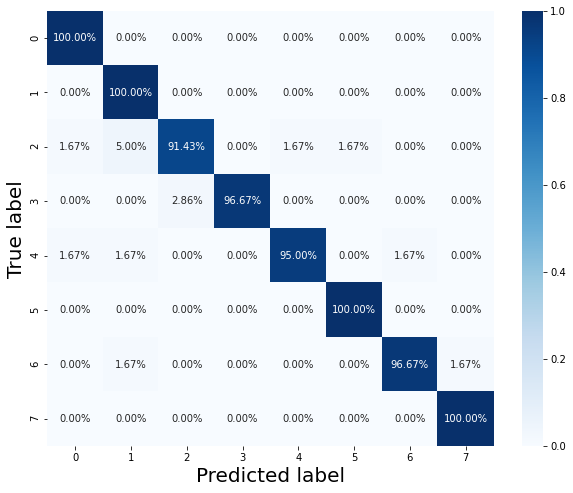

In [ ]:
# Plotting the confusion matrix for our best model

from sklearn.metrics import confusion_matrix
from seaborn import heatmap 

predictions = np.argmax(predictions_1hot, axis=1)

M = confusion_matrix(true_labels, predictions)

CM = M / M.sum(axis=1) # normalize each row (to sum = 1)

plt.figure(figsize=(10,8))
heatmap(CM,cmap='Blues',annot=True, fmt='.2%')
plt.xlabel('Predicted label', fontsize=20)
plt.ylabel('True label', fontsize=20)
plt.show()

In [ ]:
# Define a new model, to extract the activation of this layer:
features_extractor = keras.Model(inputs=model.inputs, outputs=model.layers[-2].output)

# For each of the 490 images in the validation set:
features_256D = features_extractor.predict(M4_validation_generator)
print("features_256D.shape =", features_256D.shape)

features_256D.shape = (490, 256)


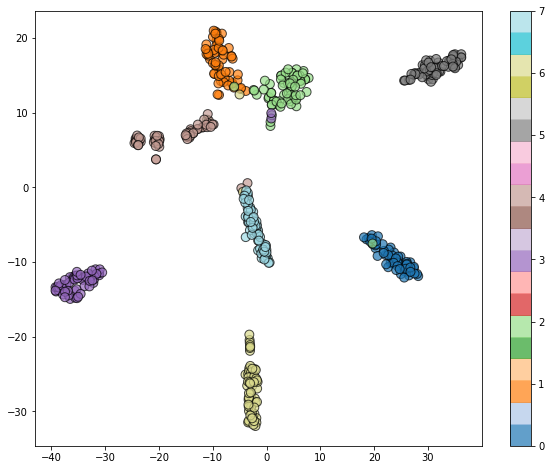

In [ ]:
# Using the one-before-last layer to visualize the labeled-data distribution in 2-D
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(features_256D)
y = M4_validation_generator.classes

plt.figure(figsize=(10,8))
plt.scatter(X_embedded[:,0],X_embedded[:,1],80,y, 
            cmap='tab20', alpha=0.7, edgecolors='k')
plt.colorbar()
plt.show()

## Using WSI to classify large images

We are going to slice the big 5000x5000 images in "real-time" and feed each slice into our model to give us a prediciton.

After we have prediction in hand we can color a canvas with the appropriate class color

In [ ]:
# Loading model from disk
model = tf.keras.models.load_model('Saved_Models/Xception')

Here we define a function that will process all of our data and return two images, one of the classification and one of the tumor heatmap.

In [ ]:
import cv2
import matplotlib.image as mpimg


def process_wsi(wsi_img_path):
    # We pad the WSI test image with white borders
    # This is done so the model sees this padding as 'Background' as per training data
    img=mpimg.imread(wsi_img_path)
    img = cv2.copyMakeBorder( img, 50, 50, 50, 50, cv2.BORDER_CONSTANT, value = (255,255,255))

    # Creating the canvases on which we will draw the classificatoin and the heatmap
    canvas_img = img.copy()
    tumor_heatmap = np.zeros((img.shape[0],img.shape[1]))

    # The smaller the value of sp the less the sliding window will move
    sp = 0.5

    # Number of patches in rows and columns, divides evenly into a padded 5100x5100 image
    nRows = int(canvas_img.shape[0]/(150*sp) - 1)
    mCols = int(canvas_img.shape[1]/(150*sp) - 1)

    # Coloring the canvas image
    for i in range(0,nRows):
        for j in range(0, mCols):

            # Extracting a 150x150 Region Of Interest from the WSI
            roi = img[int(i*150*sp) : int(i*150*sp+150), int(j*150*sp) : int(j*150*sp+150)]

            # Pre=Processing the ROI image to be input into the CNN
            input_to_model = roi/255.0
            input_to_model = np.expand_dims(input_to_model, axis=0)

            # Extracting class information
            patch_result = model.predict(input_to_model)
            prediction = np.argmax(patch_result, axis=1)[0]

            # Writing the tumor likelihood of this ROI to the tumor heatmap 
            tumor_heatmap[int(i*150*sp) : int(i*150*sp+150), int(j*150*sp) : int(j*150*sp+150)] = patch_result[0][0]

            # Color the area in the canvas according to the class
            if prediction == 0:
                cv2.rectangle(canvas_img, (int(j*150*sp),int(i*150*sp)), (int(j*150*sp+150),int(i*150*sp+150)), (232,73,25), -1)
            elif prediction == 1:
                cv2.rectangle(canvas_img, (int(j*150*sp),int(i*150*sp)), (int(j*150*sp+150),int(i*150*sp+150)), (63,174,36), -1)
            elif prediction == 2:
                cv2.rectangle(canvas_img, (int(j*150*sp),int(i*150*sp)), (int(j*150*sp+150),int(i*150*sp+150)), (247,187,15), -1)
            elif prediction == 3:
                cv2.rectangle(canvas_img, (int(j*150*sp),int(i*150*sp)), (int(j*150*sp+150),int(i*150*sp+150)), (30,149,191), -1)
            elif prediction == 4:
                cv2.rectangle(canvas_img, (int(j*150*sp),int(i*150*sp)), (int(j*150*sp+150),int(i*150*sp+150)), (193,40,153), -1)
            elif prediction == 5:
                cv2.rectangle(canvas_img, (int(j*150*sp),int(i*150*sp)), (int(j*150*sp+150),int(i*150*sp+150)), (248,219,203), -1)
            elif prediction == 6:
                cv2.rectangle(canvas_img, (int(j*150*sp),int(i*150*sp)), (int(j*150*sp+150),int(i*150*sp+150)), (142,142,142), -1)
            elif prediction == 7:
                cv2.rectangle(canvas_img, (int(j*150*sp),int(i*150*sp)), (int(j*150*sp+150),int(i*150*sp+150)), (53,53,53), -1)


    # Converting to BGR so cv2.imwrite can save the image
    canvas_img_bgr = cv2.cvtColor(canvas_img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(wsi_img_path[:-4] + '_RESULT.tif', canvas_img_bgr)

    return canvas_img, tumor_heatmap

Here we use patches to create a legend for the classification image.

For each of the 10 images the function will display side by side the original WSI, it's classification and the tumor heatmap.

In [ ]:
# Creating Legend Handles for the classification results
import matplotlib.patches as mpatches

tumorEpithelium_p = mpatches.Patch(color=(232/255.0,73/255.0,25/255.0), label='Tumor Epithelium')
stromaSimple_p = mpatches.Patch(color=(63/255.0,174/255.0,36/255.0), label='Stroma (Simple)')
stromaComplex_p = mpatches.Patch(color=(247/255.0,187/255.0,15/255.0), label='Stroma (Complex)')
immuneCells_p = mpatches.Patch(color=(30/255.0,149/255.0,191/255.0), label='Immune Cells')
debrisOrMucus_p = mpatches.Patch(color=(193/255.0,40/255.0,153/255.0), label='Debris Or Mucus')
mucosalGlands_p = mpatches.Patch(color=(248/255.0,219/255.0,203/255.0), label='Mucosal Glands')
adiposeTissue_p =  mpatches.Patch(color=(142/255.0,142/255.0,142/255.0), label='Adipose Tissue')
background_p = mpatches.Patch(color=(53/255.0,53/255.0,53/255.0), label='Background')

handleList = [tumorEpithelium_p, stromaSimple_p, stromaComplex_p, immuneCells_p, debrisOrMucus_p, mucosalGlands_p, adiposeTissue_p, background_p]

# Helper function to plot and visualize the results
def plot_wsi_results(original_wsi, canvas, heatmap):
    plt.figure(figsize=(26,8))
    plt.subplot(1,3,1)
    plt.title('Original WSI')
    plt.imshow(original_wsi)

    plt.subplot(1,3,2)
    plt.title('Classification Result')
    plt.imshow(canvas)
    plt.legend(handles=handleList, loc='lower center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)

    plt.subplot(1,3,3)
    plt.title('Tumor Epithelium')
    plt.imshow(heatmap, cmap = 'hot',)
    plt.colorbar(shrink=0.7, aspect=20*0.7)

## Displaying the results:

We use the function defined earlier to display the final result of the classification + heatmap along witht he original wsi image.

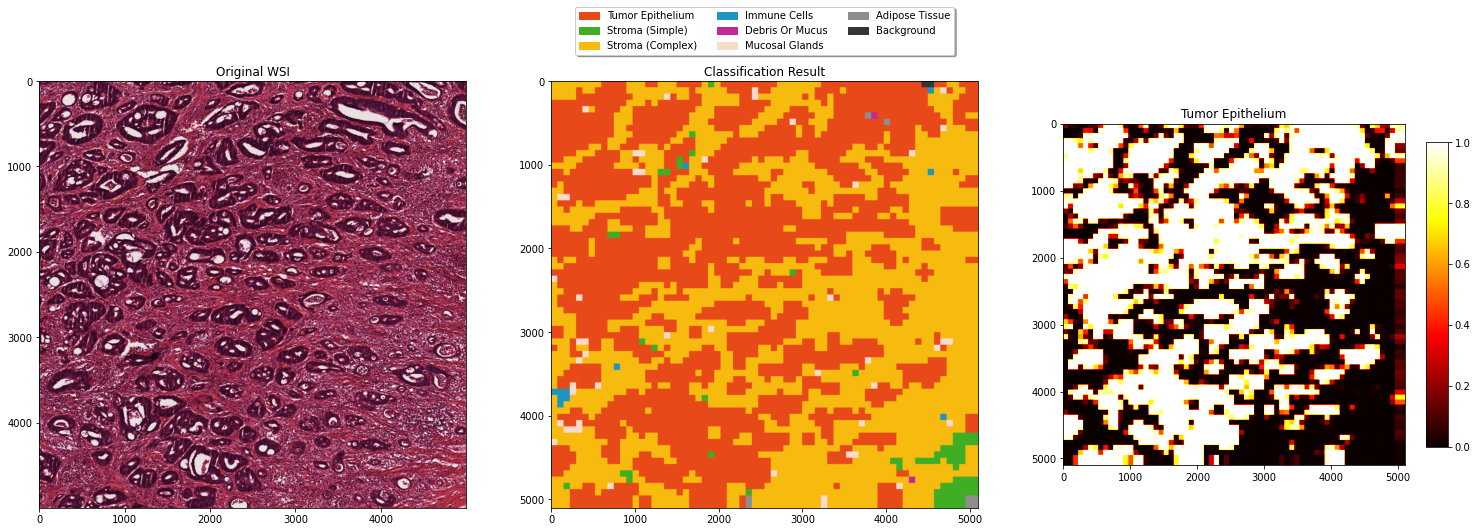

In [ ]:
wsi1_path = 'Deep_Learning_Project_Data/Kather_texture_2016_larger_images_10/CRC-Prim-HE-01_APPLICATION.tif'
wsi1 = mpimg.imread(wsi1_path)

wsi1_classification, wsi1_heatmap = process_wsi(wsi1_path)
plot_wsi_results(wsi1, wsi1_classification, wsi1_heatmap)

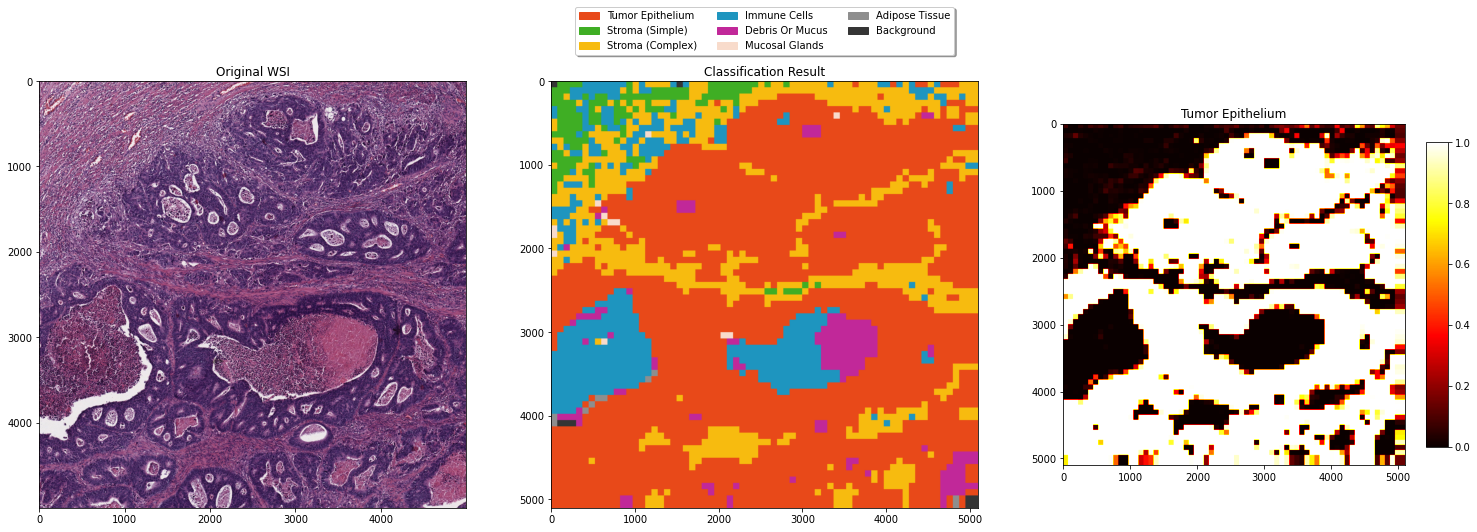

In [ ]:
wsi2_path = 'Deep_Learning_Project_Data/Kather_texture_2016_larger_images_10/CRC-Prim-HE-02_APPLICATION.tif'
wsi2 = mpimg.imread(wsi2_path)

wsi2_classification, wsi2_heatmap = process_wsi(wsi2_path)
plot_wsi_results(wsi2, wsi2_classification, wsi2_heatmap)

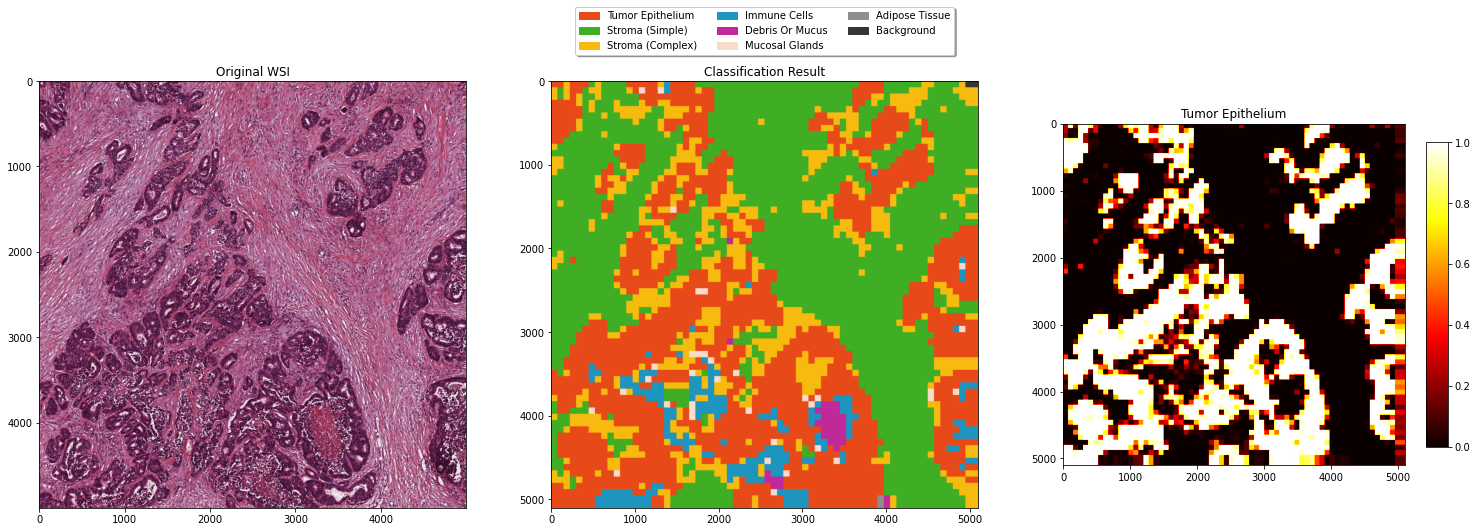

In [ ]:
wsi3_path = 'Deep_Learning_Project_Data/Kather_texture_2016_larger_images_10/CRC-Prim-HE-03_APPLICATION.tif'
wsi3 = mpimg.imread(wsi3_path)

wsi3_classification, wsi3_heatmap = process_wsi(wsi3_path)
plot_wsi_results(wsi3, wsi3_classification, wsi3_heatmap)

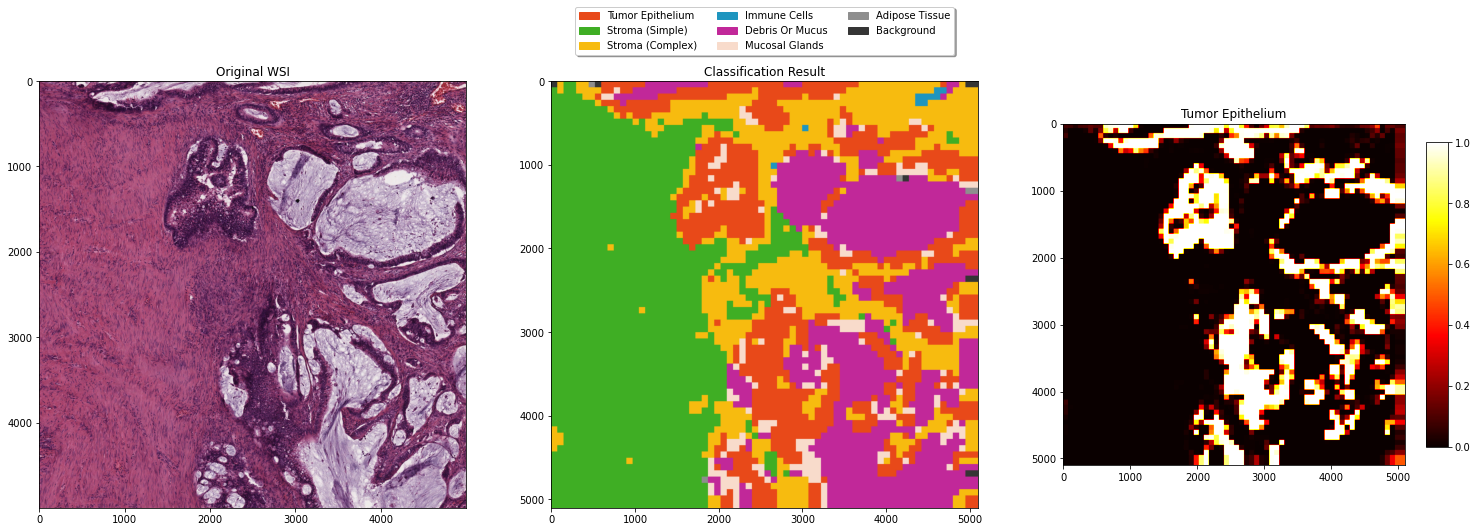

In [ ]:
wsi4_path = 'Deep_Learning_Project_Data/Kather_texture_2016_larger_images_10/CRC-Prim-HE-04_APPLICATION.tif'
wsi4 = mpimg.imread(wsi4_path)

wsi4_classification, wsi4_heatmap = process_wsi(wsi4_path)
plot_wsi_results(wsi4, wsi4_classification, wsi4_heatmap)

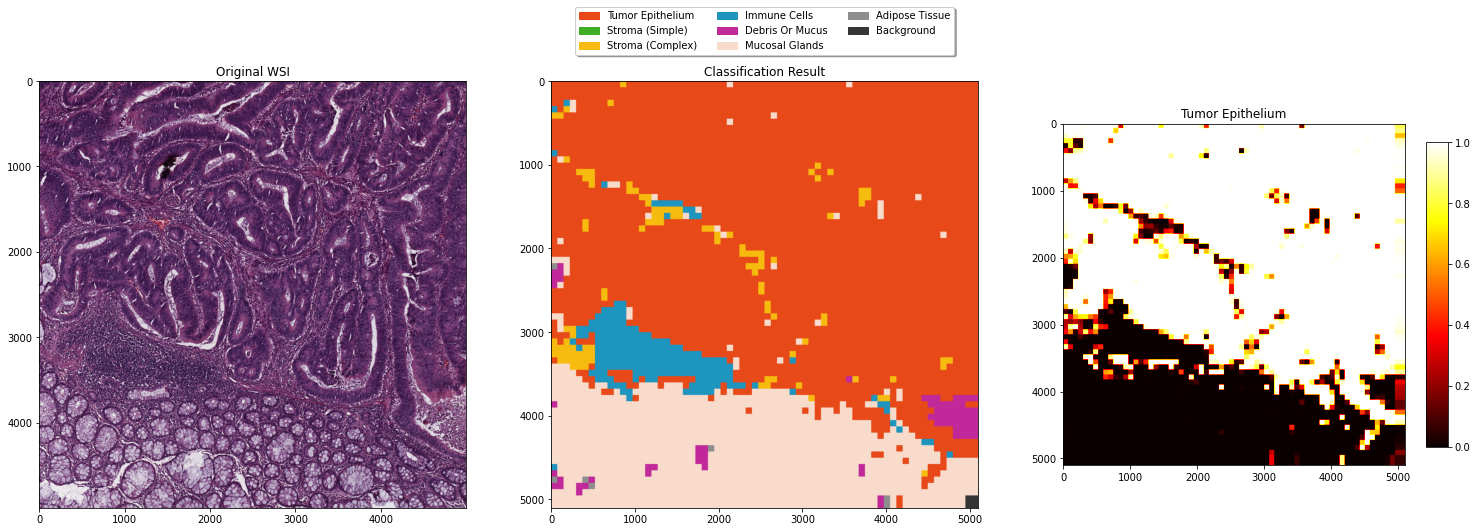

In [ ]:
wsi5_path = 'Deep_Learning_Project_Data/Kather_texture_2016_larger_images_10/CRC-Prim-HE-05_APPLICATION.tif'
wsi5 = mpimg.imread(wsi5_path)

wsi5_classification, wsi5_heatmap = process_wsi(wsi5_path)
plot_wsi_results(wsi5, wsi5_classification, wsi5_heatmap)

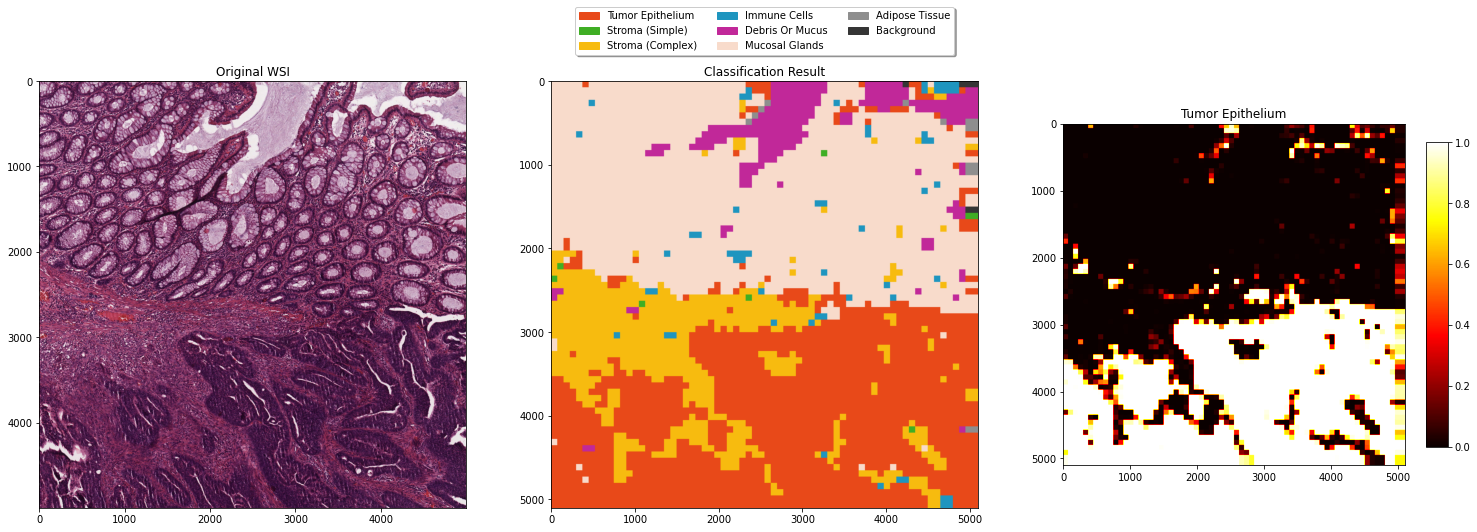

In [ ]:
wsi6_path = 'Deep_Learning_Project_Data/Kather_texture_2016_larger_images_10/CRC-Prim-HE-06_APPLICATION.tif'
wsi6 = mpimg.imread(wsi6_path)

wsi6_classification, wsi6_heatmap = process_wsi(wsi6_path)
plot_wsi_results(wsi6, wsi6_classification, wsi6_heatmap)

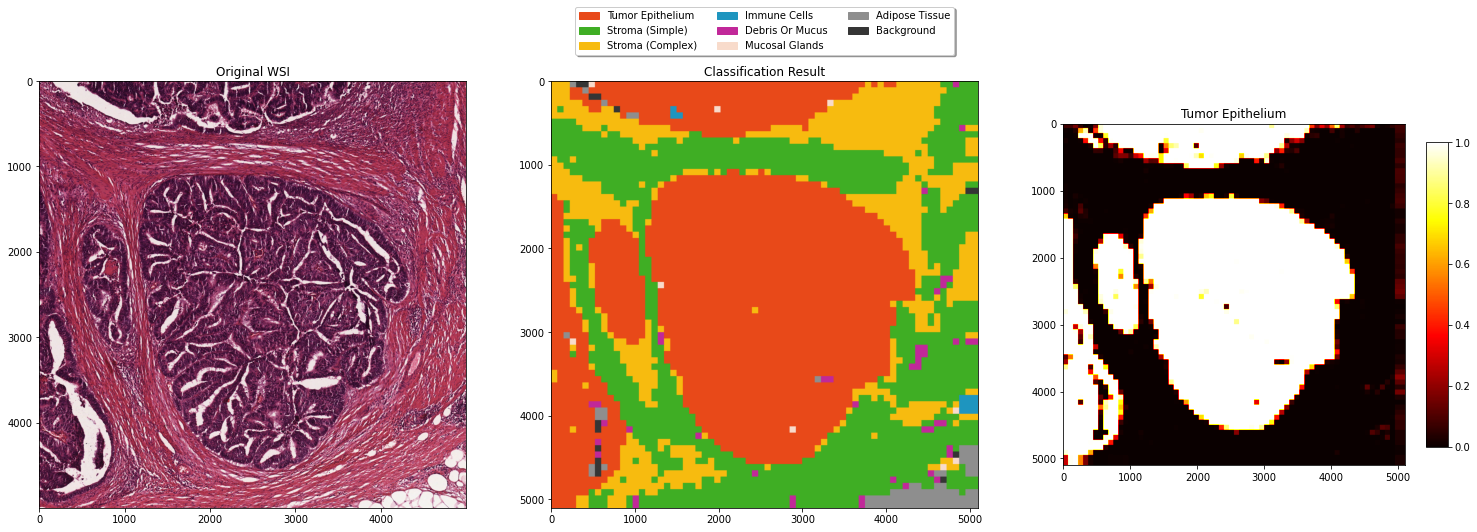

In [ ]:
wsi7_path = 'Deep_Learning_Project_Data/Kather_texture_2016_larger_images_10/CRC-Prim-HE-07_APPLICATION.tif'
wsi7 = mpimg.imread(wsi7_path)

wsi7_classification, wsi7_heatmap = process_wsi(wsi7_path)
plot_wsi_results(wsi7, wsi7_classification, wsi7_heatmap)

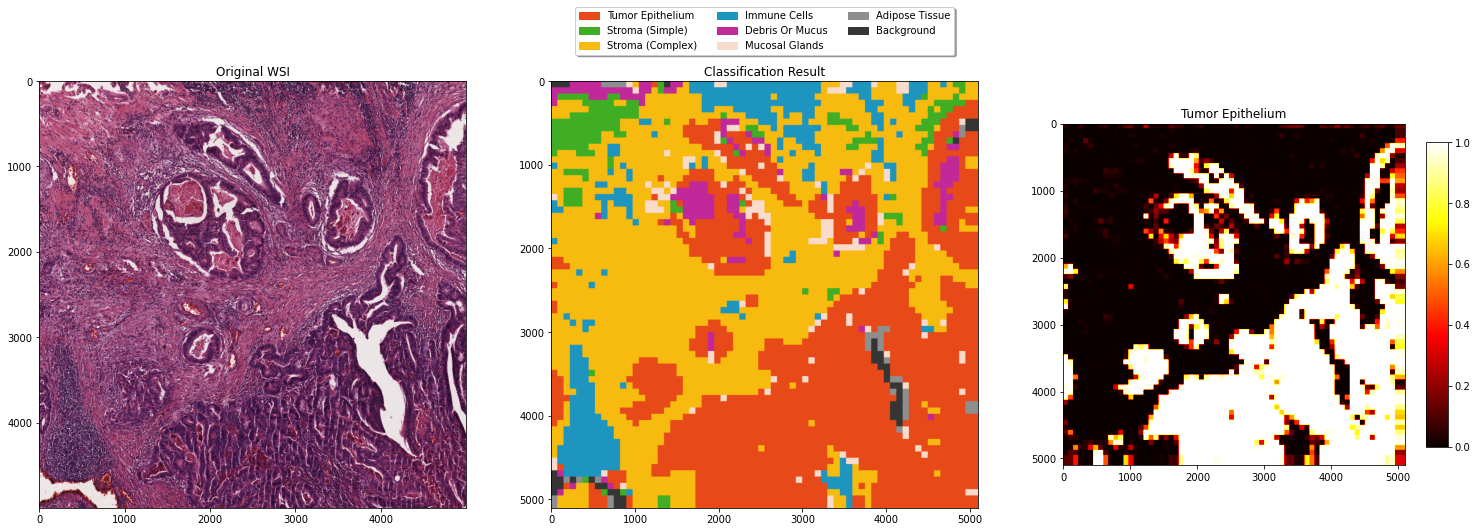

In [ ]:
wsi8_path = 'Deep_Learning_Project_Data/Kather_texture_2016_larger_images_10/CRC-Prim-HE-08_APPLICATION.tif'
wsi8 = mpimg.imread(wsi8_path)

wsi8_classification, wsi8_heatmap = process_wsi(wsi8_path)
plot_wsi_results(wsi8, wsi8_classification, wsi8_heatmap)

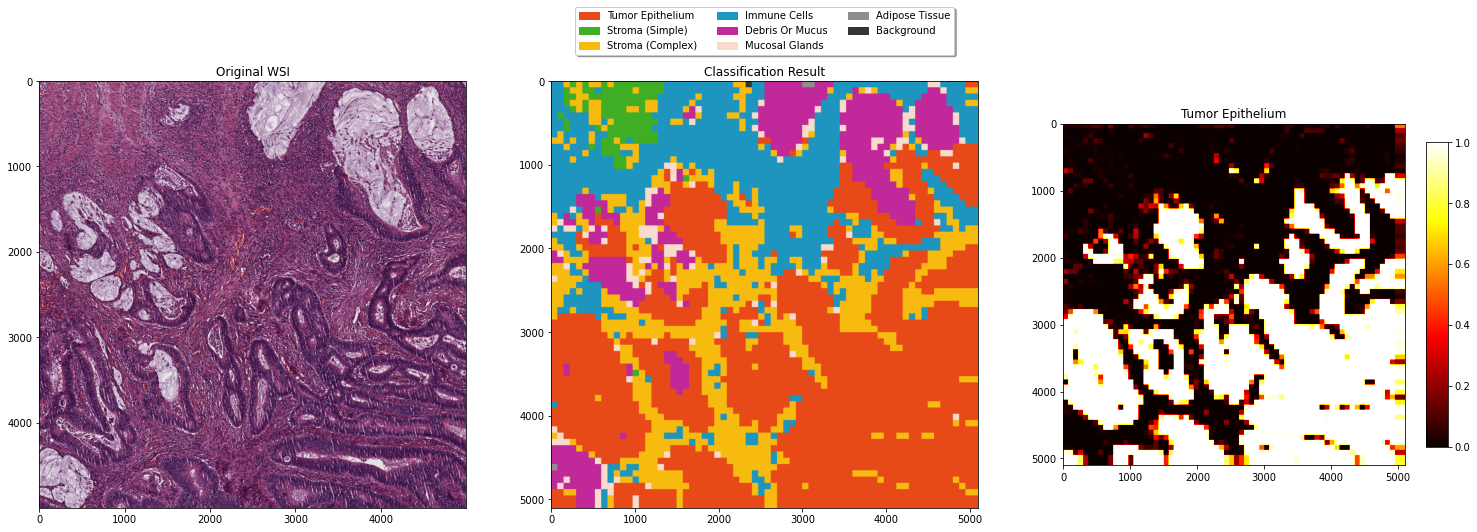

In [ ]:
wsi9_path = 'Deep_Learning_Project_Data/Kather_texture_2016_larger_images_10/CRC-Prim-HE-09_APPLICATION.tif'
wsi9 = mpimg.imread(wsi9_path)

wsi9_classification, wsi9_heatmap = process_wsi(wsi9_path)
plot_wsi_results(wsi9, wsi9_classification, wsi9_heatmap)

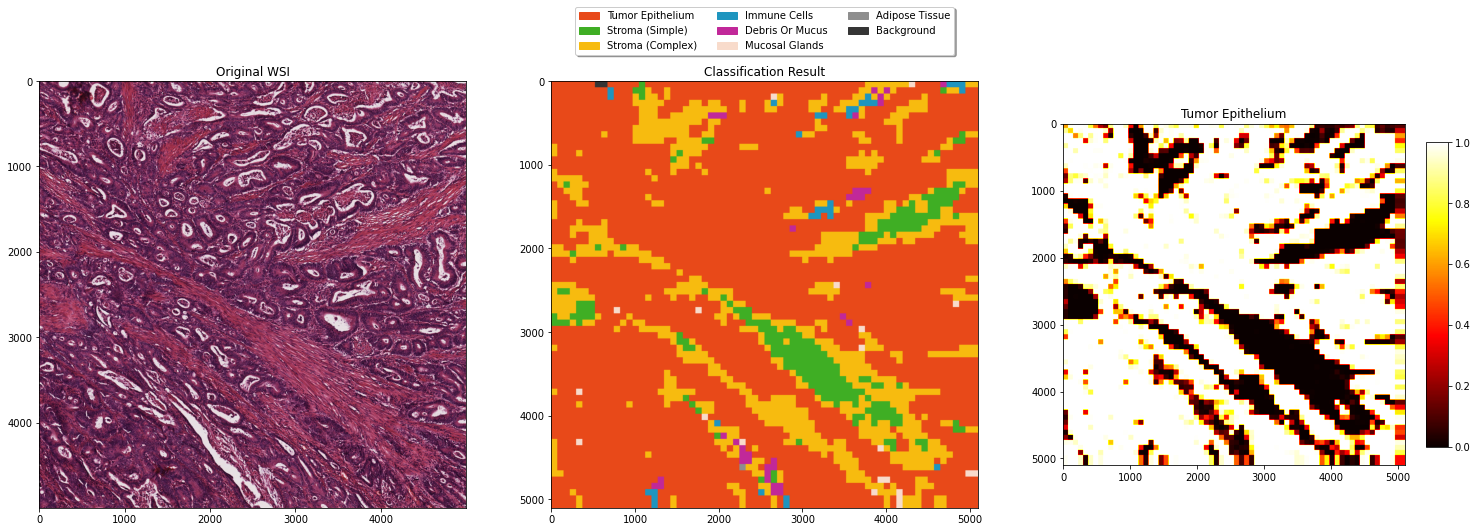

In [ ]:
wsi10_path = 'Deep_Learning_Project_Data/Kather_texture_2016_larger_images_10/CRC-Prim-HE-10_APPLICATION.tif'
wsi10 = mpimg.imread(wsi10_path)

wsi10_classification, wsi10_heatmap = process_wsi(wsi10_path)
plot_wsi_results(wsi10, wsi10_classification, wsi10_heatmap)

## Thanks for checking out our project!